In [ ]:
import torch
import torchvision 
import torchvision.datasets as datasets
import torchvision.transforms as T
import numpy as np
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import ToSLIC

In [ ]:
import matplotlib.pyplot as plt
from skimage.segmentation import slic
import skimage as ski

Example for visualization

In [ ]:
ds = datasets.MNIST(root = "./data", train=False, download=True, transform=T.ToTensor())

In [ ]:
ds.data.shape[0]

10000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(28, 28)
RAG with 65 nodes and 186 edges


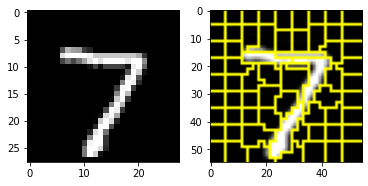

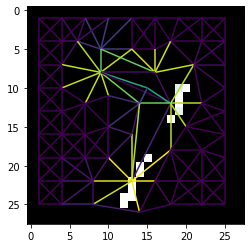

In [ ]:
i = ds.data[0].numpy()
print(i.shape)
segments = slic(i, n_segments=75, compactness=0.1)
g = ski.future.graph.rag_mean_color(i, segments)
print(g)

fig, axs = plt.subplots(1,2)
axs[0].imshow(i, "gray")
segmented_img = ski.segmentation.mark_boundaries(i, segments, mode="subpixel")
axs[1].imshow(segmented_img, "gray")
ski.future.graph.show_rag(segments, g, ski.color.gray2rgb(i), edge_cmap='viridis')


For each node compute
- mean color 
- geometric centroid

Edge index from skimage's RAG

In [ ]:
dim0, dim1 = i.shape[0], i.shape[1]
i_flat = i.flatten()
n = g.number_of_nodes()
mean_color = torch.zeros([n, 1]) # mean color
mean_pos   = torch.zeros([n, 2])
num_pixels = torch.zeros([n])
for pos in range(i_flat.shape[0]):
        node = segments[pos % dim0][int(pos / dim0)] - 1
        mean_color[node][0]   = (num_pixels[node] * mean_color[node][0]   + i_flat[pos]) / (num_pixels[node] + 1)
        mean_pos[node][0] = (num_pixels[node] * mean_pos[node][0] + (pos % dim0)) / (num_pixels[node] + 1)
        mean_pos[node][1] = (num_pixels[node] * mean_pos[node][1] + int(pos / dim0)) / (num_pixels[node] + 1)
        num_pixels[node] += 1
edge_index = torch.from_numpy(np.array(g.edges).T).to(torch.long)

SuperPixel MNIST dataset

In [ ]:
class SuperPixelGraphMNIST(InMemoryDataset):
    def __init__(self, root=None, n_segments = 75, compactness = 0.1, train = True, transform = None, pre_transform = None, pre_filter = None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = self.loadMNIST(n_segments, compactness, train)
    
    def loadMNIST(self, n_segments, compactness, train):
        mnist = datasets.MNIST('./data', train=train, download=True, transform=T.ToTensor())
        data_list = []
        img_total = mnist.data.shape[0]
        dim0, dim1 = mnist.data[0].shape[0], mnist.data[0].shape[1]
        print(f'Loading {img_total} images ...')
        for img_number, img in enumerate(mnist.data):
            img_np = img.numpy()
            s = slic(img_np, n_segments, compactness)
            g = ski.future.graph.rag_mean_color(img_np, s)
            n = g.number_of_nodes()
            x = torch.zeros([n, 1]) # mean color
            pos = torch.zeros([n, 2])
            num_pixels = torch.zeros([n])
            img_flat = img.flatten()
            for idx in range(img_flat.shape[0]):
                    node = s[idx % dim0][int(idx / dim0)] - 1
                    x[node][0]   = (num_pixels[node] * x[node][0]   + img_flat[idx]) / (num_pixels[node] + 1)
                    pos[node][0] = (num_pixels[node] * pos[node][0] + (idx % dim0)) / (num_pixels[node] + 1)
                    pos[node][1] = (num_pixels[node] * pos[node][1] + int(idx / dim0)) / (num_pixels[node] + 1)
                    num_pixels[node] += 1
            edge_index = torch.from_numpy(np.array(g.edges).T).to(torch.long)
            data = Data(x=x, edge_index=edge_index, pos=pos)
            data_list.append(data)
            if (img_number % 1000) == 0:
                print(f'{img_number}/{img_total}')
        print('Done')
        return self.collate(data_list)

In [ ]:
train_ds = SuperPixelGraphMNIST(root='./data', train=True)

Loading 60000 images ...
0/60000
1000/60000
2000/60000
3000/60000
4000/60000
5000/60000
6000/60000
7000/60000
8000/60000
9000/60000
10000/60000
11000/60000
12000/60000
13000/60000
14000/60000
15000/60000
16000/60000
17000/60000
18000/60000
19000/60000
20000/60000
21000/60000
22000/60000
23000/60000
24000/60000
25000/60000
26000/60000
27000/60000
28000/60000
29000/60000
30000/60000
31000/60000
32000/60000
33000/60000
34000/60000
35000/60000
36000/60000
37000/60000
38000/60000
39000/60000
40000/60000
41000/60000
42000/60000
43000/60000
44000/60000
45000/60000
46000/60000
47000/60000
48000/60000
49000/60000
50000/60000
51000/60000
52000/60000
53000/60000
54000/60000
55000/60000
56000/60000
57000/60000
58000/60000
59000/60000
Done


In [ ]:
test_ds = SuperPixelGraphMNIST(root='./data', train=False)

Loading 10000 images ...
0/10000
1000/10000
2000/10000
3000/10000
4000/10000
5000/10000
6000/10000
7000/10000
8000/10000
9000/10000
Done
